In [1]:
import os
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras
from keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Train Model

In [2]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    rescale= 1./255
)

train_generator = train_datagen.flow_from_directory(
    '../dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    '../dataset/val',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    '../dataset/test',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    shuffle = False
)



Found 2623 images belonging to 3 classes.
Found 561 images belonging to 3 classes.
Found 565 images belonging to 3 classes.


In [3]:
train_dir = '../dataset/train'

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {count} images")

nickels: 849 images
pennies: 899 images
quarters: 875 images


In [4]:
model = models.Sequential([
    layers.Input(shape=(224, 224,3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [5]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [6]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 15
)

Epoch 1/15
82/82 [==============================] - 73s 887ms/step - loss: 0.8165 - accuracy: 0.5986 - val_loss: 0.7248 - val_accuracy: 0.6078
Epoch 2/15
82/82 [==============================] - 79s 956ms/step - loss: 0.6621 - accuracy: 0.6904 - val_loss: 0.6928 - val_accuracy: 0.7094
Epoch 3/15
82/82 [==============================] - 76s 928ms/step - loss: 0.6279 - accuracy: 0.7236 - val_loss: 0.7707 - val_accuracy: 0.6809
Epoch 4/15
82/82 [==============================] - 80s 970ms/step - loss: 0.6091 - accuracy: 0.7400 - val_loss: 0.6233 - val_accuracy: 0.7398
Epoch 5/15
82/82 [==============================] - 79s 959ms/step - loss: 0.5861 - accuracy: 0.7514 - val_loss: 0.5948 - val_accuracy: 0.7380
Epoch 6/15
82/82 [==============================] - 75s 905ms/step - loss: 0.5668 - accuracy: 0.7777 - val_loss: 0.6794 - val_accuracy: 0.7451
Epoch 7/15
82/82 [==============================] - 69s 841ms/step - loss: 0.5567 - accuracy: 0.7789 - val_loss: 0.6131 - val_accuracy: 0.7718

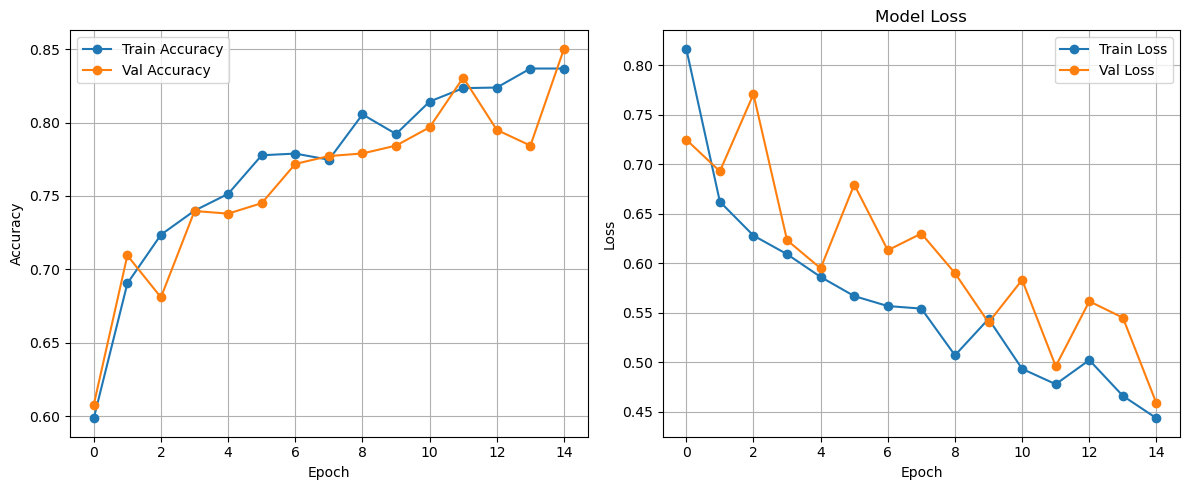

In [7]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label= 'Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 [==============================] - 4s 230ms/step - loss: 0.3876 - accuracy: 0.8549
Test Loss: 0.3876069188117981
Test Accuracy: 0.8548672795295715


In [9]:
# Get the true labels from the test generator
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

18/18 [==============================] - 4s 231ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       183
           1       0.88      0.94      0.91       194
           2       0.89      0.76      0.82       188

    accuracy                           0.85       565
   macro avg       0.86      0.85      0.85       565
weighted avg       0.86      0.85      0.85       565

Confusion Matrix:
[[158  13  12]
 [  7 182   5]
 [ 34  11 143]]


In [10]:
model.save('../models/my_model.h5')